In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import joblib
from imblearn.over_sampling import SMOTE

/home/ss00/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ss00/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ss00/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be r

In [2]:
preprocessed_df = pd.read_csv('file:///home/ss00/5_Feature_Extraction/featuredata/part-00000-a3adc2fd-91d5-4e20-9053-ab32f4068fbd-c000.csv', header = 0)

In [3]:
trainset_df = preprocessed_df.loc[preprocessed_df.dropout.isna() == False].reset_index(drop = True)
testset_df = preprocessed_df.loc[preprocessed_df.dropout.isna() == True].reset_index(drop = True)

In [4]:
trainset_df.groupby(['dropout'])['enrollment_id'].count()

dropout
False    18862
True     71715
Name: enrollment_id, dtype: int64

In [5]:
trainset_df['label'] = trainset_df['dropout'].map({True:1, False:0})

In [6]:
trainset_df.drop(columns = ['dropout'], inplace = True)
testset_df.drop(columns = ['dropout'], inplace = True)

In [25]:
X_train = trainset_df.drop(columns = ['enrollment_id', 'label']).values
Y_train = trainset_df['label'].values
X_test = testset_df.drop(columns = ['enrollment_id']).values


<Figure size 432x288 with 0 Axes>

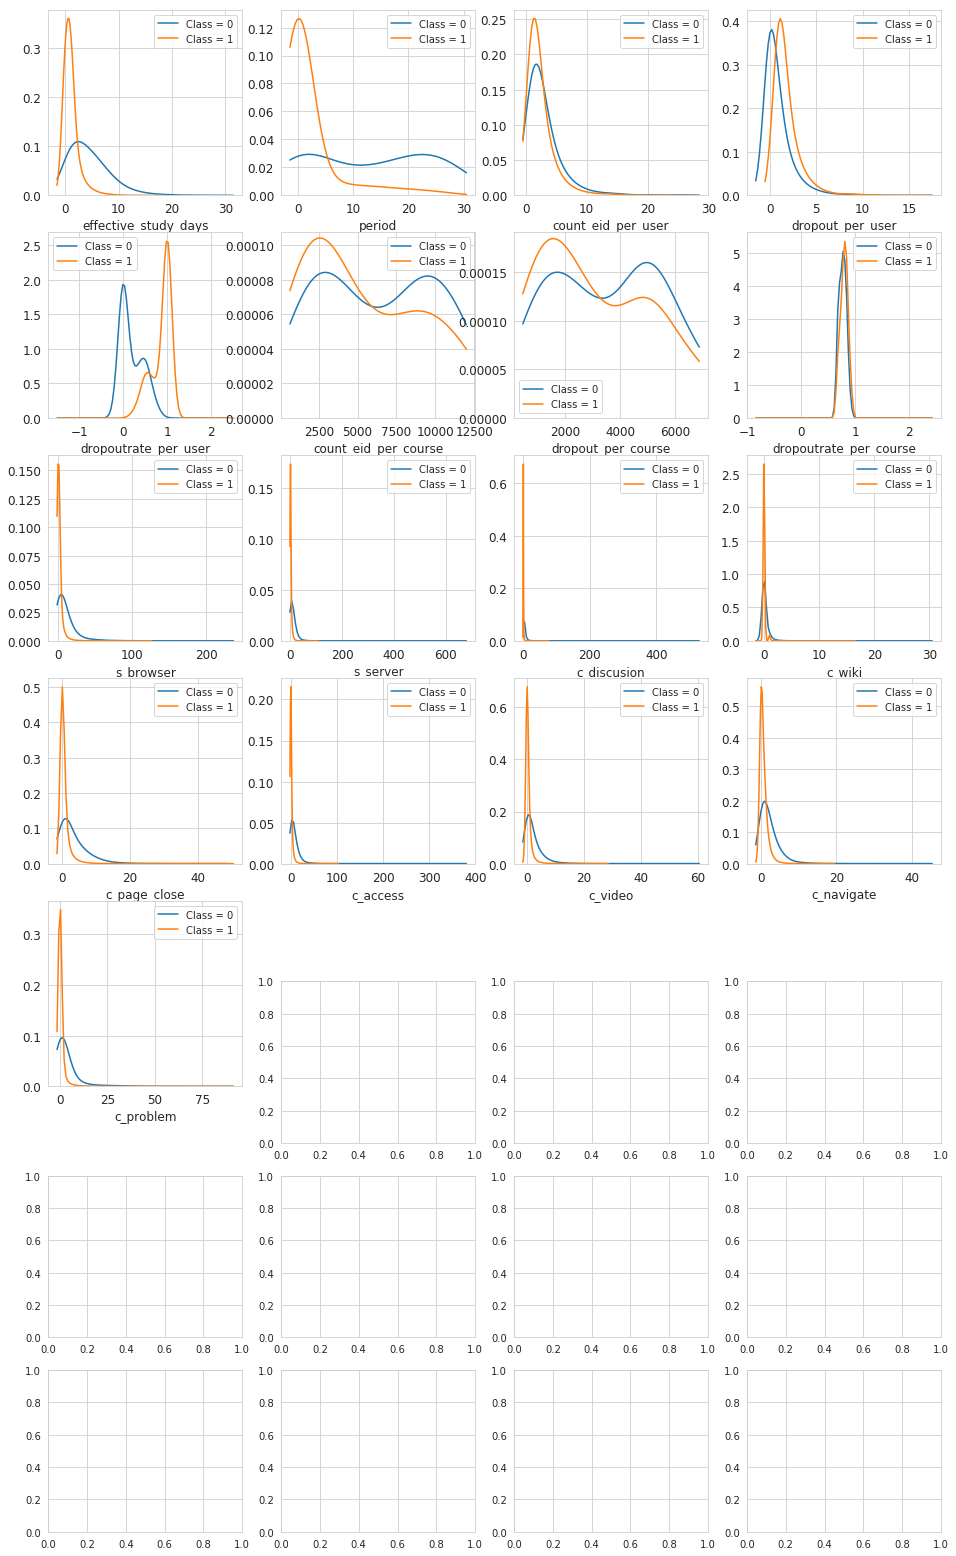

In [8]:
X_train_vis = trainset_df.drop(columns = ['enrollment_id'])
var = X_train_vis.columns.values[:-1] # V1 ~ V28
i = 0
t0 = X_train_vis.loc[X_train_vis['label'] == 0] # Class : 0 인 행만 추출
t1 = X_train_vis.loc[X_train_vis['label'] == 1] # Class : 1 인 행만 추출

sns.set_style('whitegrid') # 그래프 스타일 지정
plt.figure()
fig, ax = plt.subplots(8, 4, figsize = (16, 28)) # 축 지정

for feature in var:
    i += 1
    plt.subplot(7, 4, i) # 28개의 그래프
    sns.kdeplot(t0[feature], bw = 0.5, label = "Class = 0")
    sns.kdeplot(t1[feature], bw = 0.5, label = "Class = 1")
    plt.xlabel(feature, fontsize = 12) # 라벨 속성값
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()

## Oversampling

In [9]:
print("Before OverSampling, counts of label '1': {}".format(sum(Y_train == 1))) # y_train 중 레이블 값이 1인 데이터의 개수
print("Before OverSampling, counts of label '0': {} \n".format(sum(Y_train == 0))) # y_train 중 레이블 값이 0 인 데이터의 개수

sm3 = SMOTE(random_state = 42, ratio = 1) # SMOTE 알고리즘, Default: 동등
X_train_res, y_train_res = sm3.fit_sample(X_train, Y_train.ravel()) # Over Sampling 진행

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 71715
Before OverSampling, counts of label '0': 18862 



/home/ss00/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, counts of label '1': 71715
After OverSampling, counts of label '0': 71715


## Base model

In [10]:
models = []
models.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
models.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
models.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
models.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
models.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
models.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))
models.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))

In [11]:
scoring = 'accuracy'
n_fold = 5
sh_logic = False
kfold = KFold(n_splits = n_fold, shuffle = sh_logic)

In [12]:
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X_train_res, y_train_res, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "[%s]\tmean: %f\tstd: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)


[ScaledLR]	mean: 0.908722	std: 0.008870
[ScaledLDA]	mean: 0.906819	std: 0.008557
[ScaledKNN]	mean: 0.927170	std: 0.004171
[ScaledCART]	mean: 0.940424	std: 0.020006
[ScaledNB]	mean: 0.780653	std: 0.122619
[ScaledRF]	mean: 0.954863	std: 0.017384
[ScaledSVM]	mean: 0.902817	std: 0.016177


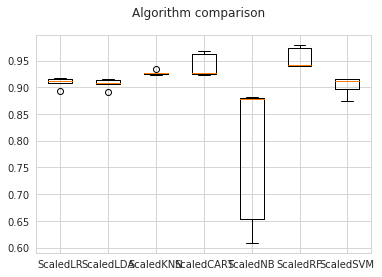

In [13]:
fig = plt.figure()
fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [14]:
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    print("Model_Evaluation with Label:1")
    print("Accuracy: ", Accuracy)
    print("Precision: ", Precision)
    print("Recall: ", Recall)
    print("F1-Score: ", F1_Score)

## Grid search for the hyper-parameters

### Random Forest

In [15]:
model = RandomForestClassifier(random_state=1234)

n_estimators_set = [100, 300, 500]
max_features_set = ["sqrt", "log2"]
param_grid = dict(n_estimators = n_estimators_set,
                  max_features = max_features_set)
param_grid_2 = {'n_estimators': n_estimators_set,
              'max_features': max_features_set}
print(param_grid)

{'n_estimators': [100, 300, 500], 'max_features': ['sqrt', 'log2']}


In [16]:
kfold = KFold(n_splits = n_fold, shuffle = sh_logic)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(X_train_res, y_train_res)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
    print(i," : ", grid_result.cv_results_[i])

Best: 0.955163 using {'n_estimators': 300, 'max_features': 'sqrt'}
mean_test_score  :  [0.95503033 0.9551628  0.9550373  0.95503033 0.9551628  0.9550373 ]
std_test_score  :  [0.01757726 0.01736512 0.01730357 0.01757726 0.01736512 0.01730357]
param_n_estimators  :  [100 300 500 100 300 500]


In [17]:
fine_tuned_RF = grid_result.best_estimator_
fine_tuned_RF.fit(X_train_res, y_train_res)
fine_tuned_RF.feature_importances_

array([0.08820547, 0.06337766, 0.04503803, 0.20385785, 0.37355054,
       0.01195461, 0.01182231, 0.01396731, 0.02278297, 0.05540681,
       0.00528207, 0.0017918 , 0.01922455, 0.03543562, 0.0119369 ,
       0.01143465, 0.02493085])

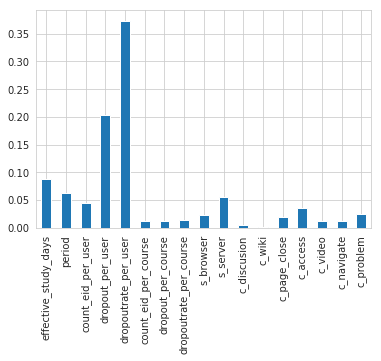

In [18]:
importances = pd.Series(fine_tuned_RF.feature_importances_, index = trainset_df.drop(columns = ['enrollment_id', 'label']).columns)
importances.plot(kind='bar')

## Prediction

In [36]:
pred_df = testset_df[['enrollment_id']]
pred_df['pred_label'] = fine_tuned_RF.predict(X_test)
pred_df.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


enrollment_id  pred_label
0           1677           0
1           1697           0
2           2509           0
3           5385           0
4           6721           0